In [3]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import os 

# in order to plot inline, Jupyter Notebook only 
%matplotlib inline

In [4]:
# Import all the .json files 
DataFolders = []
DataFolders = glob.glob('D:/DeepFakeKaggleChallenge/Data/dfdc*')

In [5]:
MetaFiles = [glob.glob(DataFolders[x] +'/*.json') for x in range(len(DataFolders))]
MetaFiles = [MetaFiles[x][0] for x in range(len(MetaFiles))]
suffix = [DataFolders[x][-2:] for x in range(len(DataFolders))]
suffix = [re.sub('_', '', suffix[x]) for x in range(len(suffix))]
MetaFilesNames = [MetaFiles[x][-13:-5] + suffix[x] for x in range(len(MetaFiles))]

In [60]:
MetaData = []
for i in tqdm(range(len(MetaFiles))):
    pivot = pd.read_json(MetaFiles[i], orient="index").reset_index().rename(columns = {'index':'name'})
    pivot["block"] = MetaFilesNames[i][-2:]
    pivot["block"] = pivot["block"].map(lambda x : x.lstrip("a"))
    pivot["block"] = pivot["block"].map(lambda x : int(x))
    MetaData.append(pivot)

c:\users\simon\anaconda3\envs\dfchallenge\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [79]:
MetaDataAll = pd.concat(MetaData, ignore_index=True)
MetaDataAll = MetaDataAll.drop(columns= ["split"])

Nearly 84% of videos are fake

In [80]:
MetaDataAll.label.value_counts(normalize=True)

FAKE    0.83925
REAL    0.16075
Name: label, dtype: float64

Meaning: some original videos are used to generate more than one fake video

In [81]:
MetaDataAll.original.value_counts().head()

tfyyefqpfs.mp4    40
rqsotnryhj.mp4    39
ypgayhhaxx.mp4    39
zgdtjzfrad.mp4    39
ivctdtckcn.mp4    38
Name: original, dtype: int64

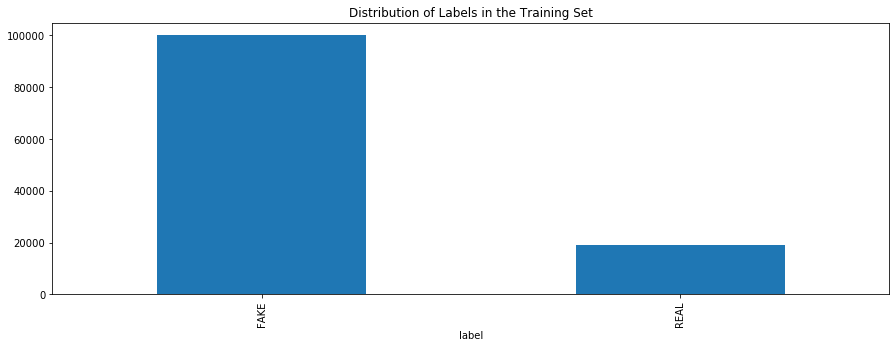

In [82]:
MetaDataAll.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

## Recovering "Lost" Frames
Let's take a look at the number of videos first

In [83]:
print("[INFO] Number of Videos: "+ str(MetaDataAll.shape[0]))
print("[INFO] Lower limit for number of frames is: "+ str(MetaDataAll.shape[0] * 32) )

[INFO] Number of Videos: 119154
[INFO] Lower limit for number of frames is: 3812928


In [84]:
#Loading all faces dataframe 
AllFaces = pd.read_pickle("all_faces_df.pkl")

In [85]:
print("[INFO] Fraction of lost frames:", np.round(1 - AllFaces.shape[0] / (MetaDataAll.shape[0] * 32), decimals= 3))
print("[INFO] Number of lost frames:", np.round((MetaDataAll.shape[0] * 32),decimals= 3))

[INFO] Fraction of lost frames: 0.015
[INFO] Number of lost frames: 3812928


In [86]:
MetaDataAll[MetaDataAll["label"] == "REAL"].shape[0]

19154

In [87]:
a = AllFaces.copy()
a = a.drop_duplicates(subset = ["filename"])

In [88]:
(MetaDataAll[MetaDataAll["label"] == "REAL"].shape[0] - a[(a["label"] == "REAL")].shape[0])/MetaDataAll[MetaDataAll["label"] == "REAL"].shape[0]

0.034457554557794715

In [110]:
LostReals = MetaDataAll[(~MetaDataAll.name.isin(a.filename))& (MetaDataAll.label == "REAL")].copy()
LostReals = LostReals.rename(columns = {"name": "filename"})
#LostReals = LostReals.drop(columns = ["name"])
#LostReals.drop(columns = ["split"])
#LostReals.to_pickle("lost_reals_df.pkl")
LostReals.head()

,filename,label,original,block
33671,jwerbdhrmu.mp4,REAL,NaN,21
60861,ahrqzxkppw.mp4,REAL,NaN,32
60997,bxtxxxylhv.mp4,REAL,NaN,32
61370,fvfzksrsbd.mp4,REAL,NaN,32
61805,kolwvxizei.mp4,REAL,NaN,32


In [108]:
LostFakes = MetaDataAll[MetaDataAll.original.isin(LostReals.filename)].copy()
LostFakes = LostFakes.rename(columns = {"name": "filename"})
LostFakes.head()

,filename,label,original,block
32915,bcqrunnwhl.mp4,FAKE,jwerbdhrmu.mp4,21
33198,eibdzfaaif.mp4,FAKE,jwerbdhrmu.mp4,21
34286,qxuivoxvhl.mp4,FAKE,jwerbdhrmu.mp4,21
34313,rfrjmsfjcz.mp4,FAKE,jwerbdhrmu.mp4,21
34353,rtneymsway.mp4,FAKE,jwerbdhrmu.mp4,21


In [114]:
LostVideos = pd.concat([LostReals, LostFakes])
LostVideos.to_pickle("lost_videos_df.pkl")